In [21]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import optuna
import torch.nn.functional as F

In [22]:
class IbuprofenEnv(gym.Env):
    def __init__(self, normalize=False):
        super(IbuprofenEnv, self).__init__()

        # Define the action space and observation space
        self.action_space = gym.spaces.Discrete(5)
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32)

        # Pharmacokinetics parameters
        self.therapeutic_range = (10, 50)
        self.half_life = 2.0
        self.clearance_rate = 0.693 / self.half_life
        self.time_step_hours = 1
        self.bioavailability = 0.9
        self.volume_of_distribution = 0.15
        self.max_steps = 24
        self.current_step = 0
        self.plasma_concentration = 0.0
        self.state_buffer = []
        self.normalize = normalize

    def reset(self, seed=None, **kwargs):
        super().reset(seed=seed)
        self.current_step = 0
        self.plasma_concentration = 0.0
        self.state_buffer = []
        state = np.array([self.plasma_concentration], dtype=np.float32)
        return self._normalize(state), {}

    def step(self, action):
        # Dose administration
        dose_mg = action * 200
        absorbed_mg = dose_mg * self.bioavailability
        absorbed_concentration = absorbed_mg / (self.volume_of_distribution * 70)
        self.plasma_concentration += absorbed_concentration
        self.plasma_concentration *= np.exp(-self.clearance_rate * self.time_step_hours)
    
        state = np.array([self.plasma_concentration], dtype=np.float32)
        normalized_state = self._normalize(state)
    
        self.state_buffer.append(self.plasma_concentration)
    
        # Reward shaping logic
        if self.therapeutic_range[0] <= self.plasma_concentration <= self.therapeutic_range[1]:
            # Positive reward for being in the therapeutic range
            reward = 10
        else:
            # Penalty for being below or above the therapeutic range
            if self.plasma_concentration < self.therapeutic_range[0]:
                penalty = (self.therapeutic_range[0] - self.plasma_concentration) * 0.1
                reward = -5 - penalty
            elif self.plasma_concentration > self.therapeutic_range[1]:
                penalty = (self.plasma_concentration - self.therapeutic_range[1]) * 0.1
                reward = -5 - penalty
    
        # Add gradual penalty for instability (fluctuations in concentration)
        if len(self.state_buffer) > 1:
            fluctuation_penalty = abs(self.state_buffer[-1] - self.state_buffer[-2]) * 0.05
            reward -= fluctuation_penalty
    
        # Add a heavy penalty for toxic concentrations
        if self.plasma_concentration > 100:
            reward -= 15  # Severe penalty for toxic levels
    
        self.current_step += 1
        done = self.current_step >= self.max_steps
        truncated = False  # For this environment, there's no specific truncation condition
        info = {}  # Additional diagnostic information
    
        return normalized_state, reward, done, truncated, info


    def _normalize(self, state):
        if self.normalize and len(self.state_buffer) > 1:
            mean = np.mean(self.state_buffer)
            std = np.std(self.state_buffer) + 1e-8
            return (state - mean) / std
        return state

In [23]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_units, num_layers):
        super(PolicyNetwork, self).__init__()
        layers = [nn.Linear(state_dim, hidden_units), nn.ReLU()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_units, hidden_units), nn.ReLU()]
        layers += [nn.Linear(hidden_units, action_dim), nn.Softmax(dim=-1)]
        self.fc = nn.Sequential(*layers)

    def forward(self, state):
        return self.fc(state)

class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_units, num_layers):
        super(ValueNetwork, self).__init__()
        layers = [nn.Linear(state_dim, hidden_units), nn.ReLU()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_units, hidden_units), nn.ReLU()]
        layers.append(nn.Linear(hidden_units, 1))
        self.fc = nn.Sequential(*layers)

    def forward(self, state):
        return self.fc(state)


In [24]:
class PPOAgent:
    def __init__(self, state_dim, action_dim, lr, gamma, eps_clip, batch_size, ppo_epochs, entropy_beta, buffer_size,
                 max_steps, hidden_units, num_layers, lambda_gae=0.95):
        self.policy = PolicyNetwork(state_dim, action_dim, hidden_units, num_layers)
        self.value = ValueNetwork(state_dim, hidden_units, num_layers)
        self.optimizer_policy = optim.Adam(self.policy.parameters(), lr=lr)
        self.optimizer_value = optim.Adam(self.value.parameters(), lr=lr)
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.batch_size = batch_size
        self.ppo_epochs = ppo_epochs
        self.entropy_beta = entropy_beta
        self.buffer_size = buffer_size
        self.max_steps = max_steps
        self.lambda_gae = lambda_gae  # For GAE


    def compute_advantage(self, rewards, values, dones):
        advantages = []
        deltas = rewards[:-1] + self.gamma * values[1:] * (1 - dones[1:]) - values[:-1]
        advantage = 0
        # Loop through in reverse order to accumulate advantages
        for delta, done in zip(reversed(deltas), reversed(dones[:-1])):
            advantage = delta + self.gamma * self.lambda_gae * advantage * (1 - done)
            advantages.insert(0, advantage)

        # Handle the last advantage by treating the last state as a terminal state
        last_value = 0 if dones[-1] else values[-1]  # Set the last value as 0 if it's a terminal state
        advantages.append(last_value)

        return np.array(advantages)

    def train(self, trajectories):
        states, actions, rewards, dones, old_probs = map(np.array, trajectories)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        old_probs = torch.tensor(old_probs, dtype=torch.float32)

        # Compute values and advantages
        values = self.value(states).squeeze()
        advantages = self.compute_advantage(rewards.numpy(), values.detach().numpy(), dones.numpy())
        advantages = torch.tensor(advantages, dtype=torch.float32)

        # Compute returns for value function target
        returns = advantages + values.detach()

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for _ in range(self.ppo_epochs):
            for i in range(0, len(states), self.batch_size):
                batch = slice(i, i + self.batch_size)
                state_batch = states[batch]
                action_batch = actions[batch]
                advantage_batch = advantages[batch]
                old_prob_batch = old_probs[batch]
                return_batch = returns[batch]

                # Policy Update
                new_probs = self.policy(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze()
                ratio = new_probs / old_prob_batch
                surr1 = ratio * advantage_batch
                surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantage_batch
                policy_loss = -torch.min(surr1, surr2).mean()

                entropy_loss = -torch.sum(new_probs * torch.log(new_probs + 1e-10), dim=-1).mean()
                policy_loss -= self.entropy_beta * entropy_loss

                self.optimizer_policy.zero_grad()
                policy_loss.backward()
                self.optimizer_policy.step()

                # **Value Function Update**
                value_preds = self.value(state_batch).squeeze()
                value_loss = F.mse_loss(value_preds, return_batch)

                self.optimizer_value.zero_grad()
                value_loss.backward()
                self.optimizer_value.step()

In [25]:
def objective(trial):
    # Define the search space for time_horizon
    time_horizon = trial.suggest_int("time_horizon", 6, 24, step=2)  # Tune from 6 to 24 in steps of 2

    # Other hyperparameters to optimize
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float("gamma", 0.90, 0.99)
    eps_clip = trial.suggest_float("eps_clip", 0.1, 0.3)
    ppo_epochs = trial.suggest_int("ppo_epochs", 3, 10)
    entropy_beta = trial.suggest_float("entropy_beta", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 32, 512, step=32)
    buffer_size = trial.suggest_int("buffer_size", batch_size * 10, batch_size * 20, step=batch_size)
    hidden_units = trial.suggest_int("hidden_units", 32, 512, step=32)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    normalize = trial.suggest_categorical("normalize", [True, False])

    # Initialize environment and PPO agent
    env = IbuprofenEnv(normalize=normalize)
    agent = PPOAgent(
        state_dim=env.observation_space.shape[0],
        action_dim=env.action_space.n,
        lr=lr,
        gamma=gamma,
        eps_clip=eps_clip,
        batch_size=batch_size,
        ppo_epochs=ppo_epochs,
        max_steps=env.max_steps,
        entropy_beta=entropy_beta,
        buffer_size=buffer_size,
        hidden_units=hidden_units,
        num_layers=num_layers,
    )

    # Training loop for Optuna
    reward_history = []

    for episode in range(100):  # Number of episodes per trial
        states, actions, rewards, dones, old_probs = [], [], [], [], []
        state, _ = env.reset()
        total_reward = 0

        for t in range(time_horizon):  # Use the sampled `time_horizon`
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = agent.policy(state_tensor).detach().numpy()
            action = np.random.choice(env.action_space.n, p=action_probs)

            new_state, reward, done, truncated, _ = env.step(action)

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            dones.append(done or truncated)
            old_probs.append(action_probs[action])

            state = new_state
            total_reward += reward

            if done or truncated:
                break

        # Train PPO with collected data
        agent.train((states, actions, rewards, dones, old_probs))
        reward_history.append(total_reward)

    # Return mean reward over episodes for Optuna to optimize
    return np.mean(reward_history)

In [26]:
# Run the Optuna Optimization
env = IbuprofenEnv(normalize=True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print the Best Hyperparameters
print("Best Hyperparameters:")
print(study.best_params)



[I 2024-12-04 14:42:07,573] A new study created in memory with name: no-name-f55beca2-7e0f-41d0-b027-c438a21af8ce
[I 2024-12-04 14:42:10,788] Trial 0 finished with value: 87.36030682535524 and parameters: {'time_horizon': 24, 'learning_rate': 1.622759604375939e-05, 'gamma': 0.9216320518659767, 'eps_clip': 0.2621565326081064, 'ppo_epochs': 7, 'entropy_beta': 0.00036648025246182567, 'batch_size': 352, 'buffer_size': 6336, 'hidden_units': 352, 'num_layers': 2, 'normalize': True}. Best is trial 0 with value: 87.36030682535524.
[I 2024-12-04 14:42:12,066] Trial 1 finished with value: -102.85274050044714 and parameters: {'time_horizon': 16, 'learning_rate': 0.00014816400282813803, 'gamma': 0.9848688407715145, 'eps_clip': 0.20168700817484864, 'ppo_epochs': 7, 'entropy_beta': 0.00023416817566439802, 'batch_size': 128, 'buffer_size': 1920, 'hidden_units': 32, 'num_layers': 1, 'normalize': True}. Best is trial 0 with value: 87.36030682535524.
[I 2024-12-04 14:42:14,844] Trial 2 finished with val

Best Hyperparameters:
{'time_horizon': 24, 'learning_rate': 0.00017526923839631796, 'gamma': 0.9300332871920146, 'eps_clip': 0.275768189845041, 'ppo_epochs': 5, 'entropy_beta': 0.0012168271435102857, 'batch_size': 320, 'buffer_size': 5120, 'hidden_units': 448, 'num_layers': 2, 'normalize': False}


In [27]:

# Train the Agent with the Best Hyperparameters
best_params = study.best_params
agent = PPOAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    lr=best_params["learning_rate"],
    gamma=best_params["gamma"],
    eps_clip=best_params["eps_clip"],
    batch_size=best_params["batch_size"],
    ppo_epochs=best_params["ppo_epochs"],
    entropy_beta=best_params["entropy_beta"],
    buffer_size=best_params["buffer_size"],
    max_steps=env.max_steps,
    hidden_units=best_params["hidden_units"],
    num_layers=best_params["num_layers"],
)


buffer_size = best_params["buffer_size"]  # From hyperparameter optimization
batch_size = best_params["batch_size"]
# Initialize variables for dynamic time horizon
initial_horizon = 6  # Start with a small time horizon
max_horizon = 24     # Full time period (24 hours, in your case)
horizon_increment = 2  # Increase the horizon incrementally
time_horizon = initial_horizon

reward_history = []

for episode in range(1000):  # Number of training episodes

    time_horizon = min(max_horizon, initial_horizon + episode * horizon_increment)

    states, actions, rewards, dones, old_probs = [], [], [], [], []
    state, _ = env.reset()  # Reset environment at the start of the episode
    total_reward = 0

    for t in range(time_horizon):  # Use the dynamic time horizon instead of fixed `max_steps`
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_probs = agent.policy(state_tensor).detach().numpy()
        action = np.random.choice(env.action_space.n, p=action_probs)

        new_state, reward, done, truncated, _ = env.step(action)

        # Store transitions
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done or truncated)
        old_probs.append(action_probs[action])

        state = new_state
        total_reward += reward

        if done or truncated:
            break

    # Train PPO with collected trajectories
    agent.train((states, actions, rewards, dones, old_probs))
    reward_history.append(total_reward)

    # Log progress
    if episode % 50 == 0:
        print(f"Episode {episode}: Total Reward = {total_reward}, Time Horizon = {time_horizon}")


Episode 0: Total Reward = 7.7622000074302555, Time Horizon = 6
Episode 50: Total Reward = 222.04804792875217, Time Horizon = 24
Episode 100: Total Reward = 238.5367964112594, Time Horizon = 24
Episode 150: Total Reward = 238.5367964112594, Time Horizon = 24
Episode 200: Total Reward = 238.5367964112594, Time Horizon = 24
Episode 250: Total Reward = 238.5367964112594, Time Horizon = 24
Episode 300: Total Reward = 238.5367964112594, Time Horizon = 24
Episode 350: Total Reward = 238.5367964112594, Time Horizon = 24
Episode 400: Total Reward = 238.5367964112594, Time Horizon = 24
Episode 450: Total Reward = 238.5367964112594, Time Horizon = 24
Episode 500: Total Reward = 238.5367964112594, Time Horizon = 24
Episode 550: Total Reward = 238.5367964112594, Time Horizon = 24
Episode 600: Total Reward = 238.5367964112594, Time Horizon = 24
Episode 650: Total Reward = 238.5367964112594, Time Horizon = 24
Episode 700: Total Reward = 238.5367964112594, Time Horizon = 24
Episode 750: Total Reward =

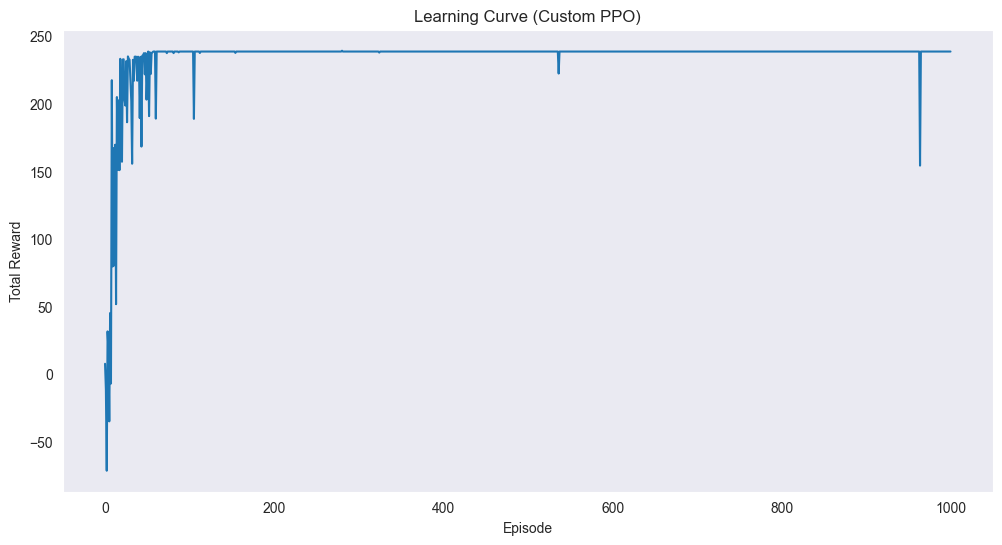

In [28]:
# Plot rewards
plt.figure(figsize=(12, 6))
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Learning Curve (Custom PPO)")
plt.grid()
plt.show()

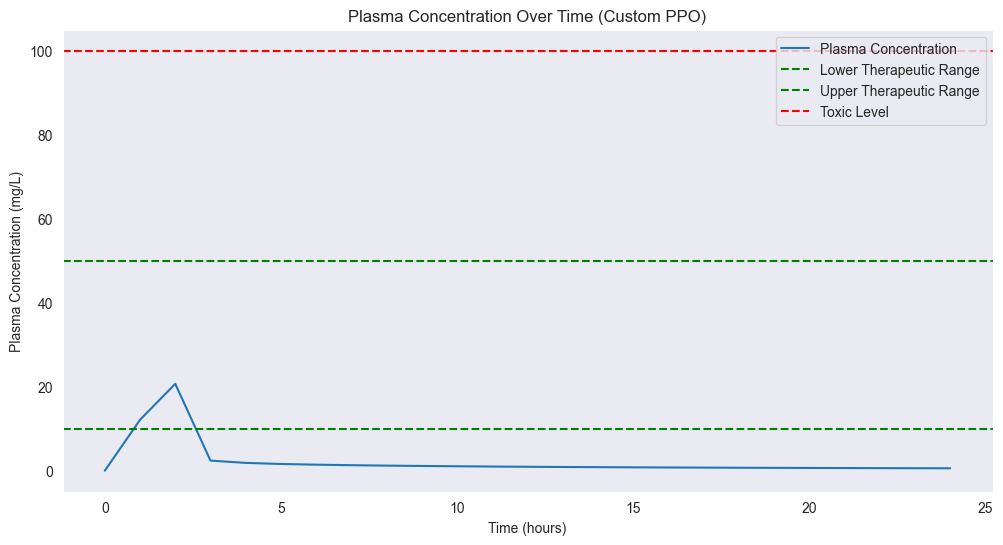

In [29]:
# Evaluation Loop
evaluation_episodes = 100  # Number of episodes for evaluation
state, _ = env.reset()

evaluation_rewards = []
plasma_concentration_trajectories = []

for episode in range(evaluation_episodes):
    state, _ = env.reset()
    total_reward = 0
    plasma_concentration_history = [state[0]]  # Track plasma concentration

    for _ in range(env.max_steps):  # Use max_steps from environment
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probs = agent.policy(state_tensor).detach().numpy().flatten()
        action = np.argmax(action_probs)  # Greedy action selection for evaluation

        new_state, reward, done, truncated, _ = env.step(action)
        plasma_concentration_history.append(new_state[0])

        state = new_state
        total_reward += reward

        if done or truncated:
            break

    evaluation_rewards.append(total_reward)
    plasma_concentration_trajectories.append(plasma_concentration_history)

# Plot plasma concentration from the last evaluation episode
plt.figure(figsize=(12, 6))
plt.plot(plasma_concentration_trajectories[-1], label="Plasma Concentration")
plt.axhline(y=env.therapeutic_range[0], color="g", linestyle="--", label="Lower Therapeutic Range")
plt.axhline(y=env.therapeutic_range[1], color="g", linestyle="--", label="Upper Therapeutic Range")
plt.axhline(y=100, color="r", linestyle="--", label="Toxic Level")
plt.xlabel("Time (hours)")
plt.ylabel("Plasma Concentration (mg/L)")
plt.title("Plasma Concentration Over Time (Custom PPO)")
plt.legend()
plt.grid()
plt.show()

In [30]:
optuna.visualization.plot_optimization_history(study).show()


In [31]:
optuna.visualization.plot_param_importances(study).show()

In [32]:
therapeutic_range_times = []

for trajectory in plasma_concentration_trajectories:
    time_in_range = sum(env.therapeutic_range[0] <= c <= env.therapeutic_range[1] for c in trajectory)
    therapeutic_range_times.append(time_in_range / len(trajectory))

avg_time_in_therapeutic_range = np.mean(therapeutic_range_times)
print(f"Average Time in Therapeutic Range: {avg_time_in_therapeutic_range * 100:.2f}%")


Average Time in Therapeutic Range: 8.00%


In [33]:

toxic_level_exceedances = sum(c > 100 for trajectory in plasma_concentration_trajectories for c in trajectory)
print(f"Toxic Level Exceedances Across All Episodes: {toxic_level_exceedances}")

survival_rate = sum(1 for trajectory in plasma_concentration_trajectories if max(trajectory) <= 100) / len(plasma_concentration_trajectories)
print(f"Survival Rate: {survival_rate * 100:.2f}%")

Toxic Level Exceedances Across All Episodes: 0
Survival Rate: 100.00%


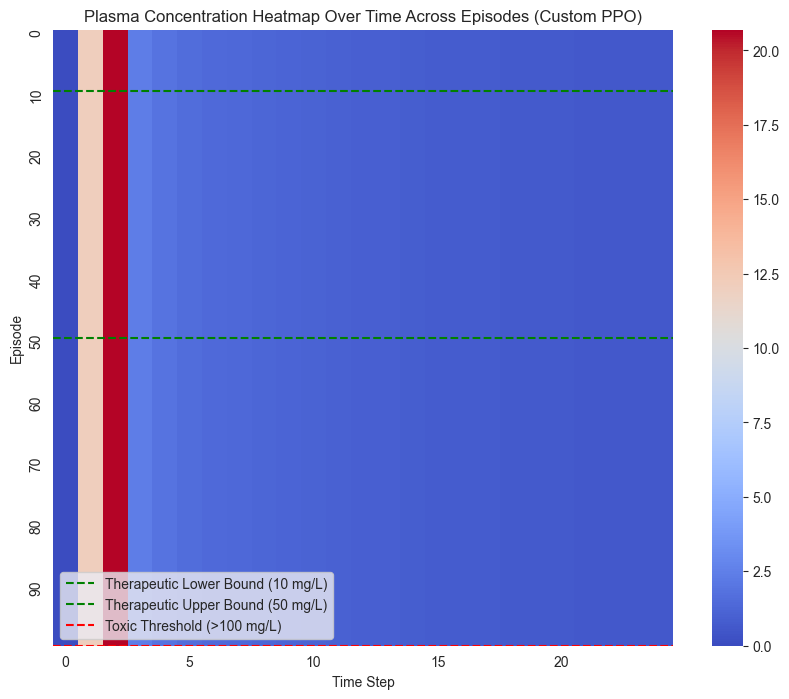

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following line has been executed previously:
# plasma_concentration_trajectories = store plasma concentration data from evaluation episodes

# Convert the list of plasma concentrations into a 2D array (episodes x time steps)
# Each row in plasma_concentration_trajectories corresponds to one episode's concentration over time
plasma_concentrations_matrix = np.array(plasma_concentration_trajectories)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(plasma_concentrations_matrix, cmap='coolwarm', annot=False, cbar=True, xticklabels=5, yticklabels=10)

# Add horizontal lines for therapeutic range and toxic threshold
plt.axhline(y=10, color='g', linestyle='--', label='Therapeutic Lower Bound (10 mg/L)')
plt.axhline(y=50, color='g', linestyle='--', label='Therapeutic Upper Bound (50 mg/L)')
plt.axhline(y=100, color='r', linestyle='--', label='Toxic Threshold (>100 mg/L)')

# Labeling and formatting the plot
plt.xlabel('Time Step')
plt.ylabel('Episode')
plt.title('Plasma Concentration Heatmap Over Time Across Episodes (Custom PPO)')
plt.legend()
plt.grid(True)
plt.show()


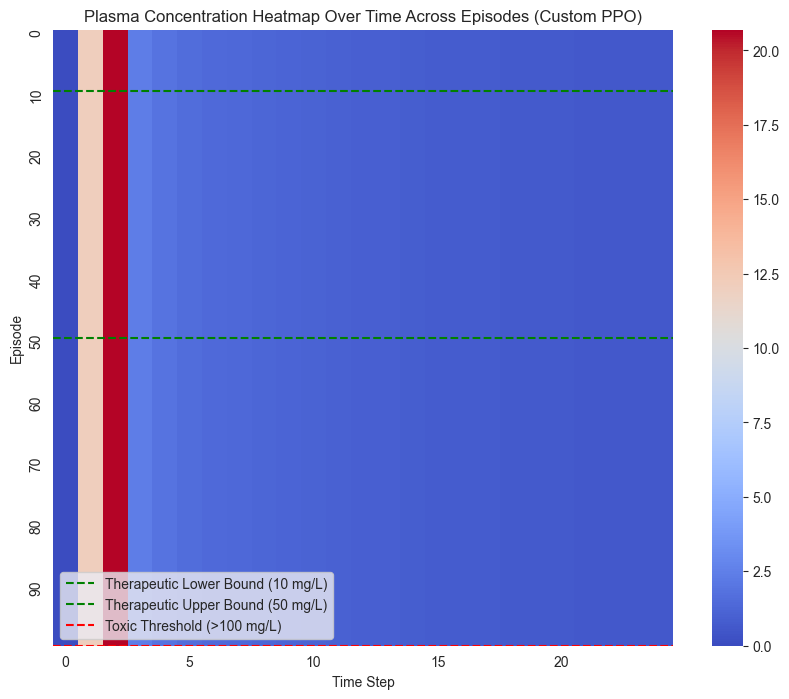

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following line has been executed previously:
# plasma_concentration_trajectories = store plasma concentration data from evaluation episodes

# Convert the list of plasma concentrations into a 2D array (episodes x time steps)
# Each row in plasma_concentration_trajectories corresponds to one episode's concentration over time
plasma_concentrations_matrix = np.array(plasma_concentration_trajectories)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(plasma_concentrations_matrix, cmap='coolwarm', annot=False, cbar=True, xticklabels=5, yticklabels=10)

# Add horizontal lines for therapeutic range and toxic threshold
plt.axhline(y=10, color='g', linestyle='--', label='Therapeutic Lower Bound (10 mg/L)')
plt.axhline(y=50, color='g', linestyle='--', label='Therapeutic Upper Bound (50 mg/L)')
plt.axhline(y=100, color='r', linestyle='--', label='Toxic Threshold (>100 mg/L)')

# Labeling and formatting the plot
plt.xlabel('Time Step')
plt.ylabel('Episode')
plt.title('Plasma Concentration Heatmap Over Time Across Episodes (Custom PPO)')
plt.legend()
plt.grid(True)
plt.show()


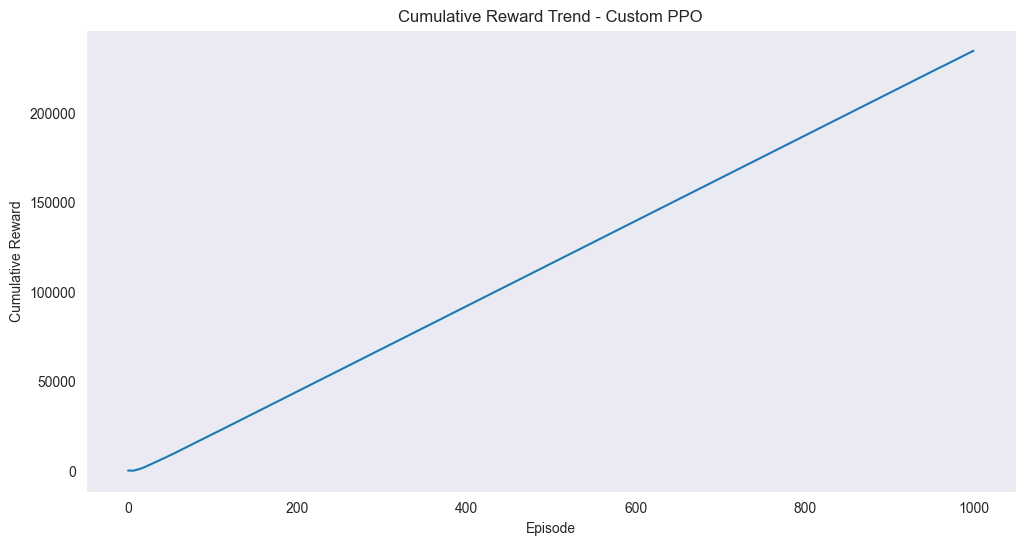

In [36]:

cumulative_rewards = np.cumsum(reward_history)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_rewards)
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward Trend - Custom PPO")
plt.grid()
plt.show()